# Generate word clusters with k-means algorithm for application of NLP

### Local minima is common in k-mean algorithm because the algorithm is very sensitive to the initialization of centroids.
### Solution: Run multiple times to choose the lowest cost possible.

Before doing k-means algorithm, we should notice that k-means is sensitive to the scale of the data, if data itself
is too big (e.g., ~1e6), then the euclidean distance between a centroid and any datapoint will scale to ~1e12. Therefore,
before doing k-means, it's always safe to first normalize the data.

Secondly, k-means is sensative to large dataset since the cost is the summation of all euclidean distances. Therefore,
we can scale down the cost by dividing the cost by D and N.

Finally, there is no "overfitting" for k-means algo even if k(cluster number) is extremely large (k~N), because "overfitting" only exists in the supervised ml problems. "Overfitting" means model is too fit for training dataset, but not quite fit for test dataset. But we should always be careful when choosing k.


In [56]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import re

In [57]:
class Initialization():
    
    
    def __init__(self,N,D):
        
        self.D = D
        self.N = N
        self.Y = None
        self.X = None
        
    def data_initialization(self):
        
        N = self.N
        D = self.D
        
        # define centroids of six clusters
        c1 = np.array([0,0])
        c2 = np.array([-10,-10])
        c3 = np.array([-2,-5])
        c4 = np.array([6,6])
        c5 = np.array([2,8])
        c6 = np.array([8,15])
        
        X = np.zeros((N,D))
        Y = np.zeros(N)
        indx = int(N/6)
        X[:indx,:] = np.random.randn(indx,D) + c1
        X[indx:2*indx,:] = np.random.randn(indx,D) + c2
        X[2*indx:3*indx,:] = np.random.randn(indx,D) + c3 
        X[3*indx:4*indx:,:] = np.random.randn(indx,D) + c4 
        X[4*indx:5*indx:,:] = np.random.randn(indx,D) + c5 
        X[5*indx:,:] = np.random.randn(indx,D) + c6
        Y[:indx] = 0
        Y[indx:2*indx] = 1
        Y[2*indx:3*indx] = 2
        Y[3*indx:4*indx:] = 3
        Y[4*indx:5*indx:] = 4
        Y[5*indx:] = 5
        self.X = X
        self.Y = Y
        return X
    
    def data_visualization(self):
        
        X = self.data_initialization()

        D = self.D
        
        if D == 2:
            plt.scatter(X[:,0],X[:,1])
            plt.title("raw data without cluster classification")
            plt.show()
        
        elif D > 2:
            tsne = TSNE()
            Y = tsne.fit_transform(X)
            plt.scatter(Y[:,0],Y[:,1])
            plt.title("raw data without cluster classification")
            plt.show()   
            
        else:
            
            print("Dimension of data cannot be 1.")
            
            
            

In [86]:
class soft_k_means():
    
    def __init__(self,beta,N,epochs,num_of_clusters,data):
        
        self.costs = None
        self.beta = beta
        self.epochs = epochs
        self.N = N
        self.num_of_clusters = num_of_clusters
        self.data = data
        self.W = None
        self.clusters = None
        
    def train(self,soft,plot):
 
        data = self.data
        num_of_clusters = self.num_of_clusters
        N = self.N
        beta = self.beta
        clusters = self.clusters
        self.costs = []
        inds = np.random.choice(N,num_of_clusters,replace=False)
        clusters = data[inds,:]
        
        #define weights for soft k-means
        W = np.zeros((N,num_of_clusters))
       
        
        
        if soft == False:
            
            for it in tqdm(range(self.epochs)):
                self.clusters_lst = [[] for _ in range(num_of_clusters)]
                for i in range(N):                
                    min_distance = np.inf
                    min_j = 0
                    for j in range(num_of_clusters):                 
                        dist = self.distance(data[i,:],clusters[j,:])
                        if dist<min_distance:
                            min_distance = dist
                            min_j = j
                    self.clusters_lst[min_j].append(i)
                
                cost = self.cost_function_hard(clusters)
                self.costs.append(cost)
                
                #redefine the new clusters for the next iteration
                for indx,indx_lst in enumerate(self.clusters_lst):
                    clusters[indx,:] = data[indx_lst,:].mean(axis=0)
            
            self.clusters = clusters
            
            
        

        else:
            
            plt.figure(figsize=(6,150))
            random_colors = np.random.random((self.num_of_clusters,3))
            for it in tqdm(range(self.epochs)):
                # For soft k-means, we can choose to plot each epoch
                if plot==True:
                    
                    W_certain = np.zeros_like(W)
                    for i in range(N):
                        j = W[i,:].argmax()       
                        W_certain[i,j] = 1      
                    C = W_certain.shape[1]

                    # Or we can use random colors
                    
                    #random_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b','#1377f4',\
                                    #'#2a72b4','#4f77a8','#0f57c4']

                    for i in range(C):
                        indx = np.where(W_certain[:,i]==1)
                        plt.subplot(self.epochs,1,it+1)
                        plt.scatter(self.data[indx,0],self.data[indx,1],c=random_colors[i])
                        plt.title("Clusters after soft-k means algorithm")
                
                
                for i in range(N):
                    
                    denominator = np.sum(np.exp(-beta*self.distance(data[i,:],clusters[m,:])) for m in range(num_of_clusters))
                    for j in range(num_of_clusters):
                        W[i,j] = np.exp(-beta*self.distance(data[i,:],clusters[j,:])) / denominator 
                cost = self.cost_function_soft(W,data,clusters)
                self.costs.append(cost)

                #redefine the new clusters for the next iteration
                for i in range(num_of_clusters):
                    clusters[i,:] = W[:,i].dot(data)/np.sum(W[:,i])        

            self.W = W
            self.clusters = clusters
        
    def cost_function_soft(self,W,X,C):  
        
        cost = 0 

        for i in range(self.num_of_clusters):

            dist_arr = np.array([self.distance(X[j,:],C[i,:]) for j in range(self.N)])
            avg_cost = W[:,i].dot(dist_arr)/self.N 
            cost+=avg_cost
        
        cost/=self.num_of_clusters
            

        return cost 
    
    def cost_function_hard(self,C):
        
        cost=0
        for indx,indx_lst in enumerate(self.clusters_lst):
            dist_arr = np.array([self.distance(self.data[j,:],C[indx,:]) for j in indx_lst])
            avg_cost = dist_arr.sum()/len(indx_lst)
            cost+=avg_cost
        cost/=len(self.clusters_lst)
        return cost

    def distance(self,X,Y):
        
        """
        We use Euclidean distance instead of Cosine distance here because let's consider two vectors:
        
        [1,2,3] and [-1000,-1000,1000], their cosine distance is zero but these two points have a
        
        large euclidean distance. They should not be in the same cluster.
              
        """
        dis = np.sqrt((X-Y).dot((X-Y)))
        
        return dis
    
    def DBI(self):
        
        """
        
        This method computes DBI of SOFT-K-MEANS algo. Soft-k-means algo needs weights when computing DBI.
        
        DBI is an internal validation method (no need of true labels) for determining the best model of k-means algo.
        
        It has two usage:
        
        (1) With a fixed cluster number k, sometimes the model reaches local minima, meaning the model is not
        
        the best one for clustering. In this case, in addition to observe the cost value (we need to get a final cost
        as low as possible), we can also observe DBI, since the optimal model (with global minima) has the lowest DBI.
        
        (2) We can also use DBI to roughly determine the best cluster number k. The optimal-k model could yield the lowest DBI,
        
        though we cannot solely rely on DBI to determine k because let's consider an extreme case where k = N (each point is a
        
        cluster), then DBI would be zero in that case. Nonetheless, DBI can determine an optimal k in a certain range of k.
        
        To determine k more accurately, we should also resort to elbow method.
        
        
        Note: the numerator of DBI can be viewed as the deviation of datapoint from centroids. A best case of clustering
        
        would be a smallest deviation(numerator) combining with a biggest centroid distance (denominator), which yields a lowest DBI.
        
        
        
        """
        
        W = self.W
        clusters = self.clusters
        data = self.data
        N = self.N
        
        DBI_total = []
        for cluster_indx_i, cluster_i in tqdm(enumerate(clusters)):
            
            k_sigma = 0
            for data_indx_i, x in enumerate(data):
                k_sigma+=W[data_indx_i,cluster_indx_i]*self.distance(x,cluster_i)
            k_sigma/=N
            
            
            j_sigma = 0
            DBIs = []
            for cluster_indx_j, cluster_j in enumerate(clusters):
                
                if cluster_indx_i == cluster_indx_j:
                    
                    continue
                
                for data_indx_j, x in enumerate(data):
                    j_sigma+=W[data_indx_j,cluster_indx_j]*self.distance(x,cluster_j)
                
                j_sigma/=N

                DBI = (k_sigma+j_sigma)/self.distance(cluster_i,cluster_j)
                DBIs.append(DBI)
        
            DBI_max = np.max(DBIs)
            DBI_total.append(DBI_max)
        
        overall_DBI = np.sum(DBI_total)/self.num_of_clusters
        
        return overall_DBI
                
    
    def purity(self,label):
        
        """
        Purity is another method to evaluate a k-means clustering, but it requires true labels. Therefore, it is
        
        called an external validation method. If we had true labels, we might as well do supervised machine learning
        
        for classification problem.
        """
        
        W = self.W
        clusters = self.clusters
        data = self.data
        N = self.N   
        indx_lst = [[] for _ in range(self.num_of_clusters)]
        label_count = []
        for i in range(N): 
            indx_lst[W[i,:].argmax()].append(i)
        
        for k in range(self.num_of_clusters):
            
            label_count_per_k = []
            
            for i in range(self.num_of_clusters):
                
                c = 0 
                
                for j in np.where(label==i)[0]:
                                       
                    if j in indx_lst[k]:

                        c+=1
                
                label_count_per_k.append(c)
                
            label_count.append(np.max(label_count_per_k))
        
        purity = np.sum(label_count)/N
        
        return purity
            
        
    
    def plot_clusters(self,soft,uncertainty=False):
        
        
        if soft == False:
            
            C = len(self.clusters_lst) 
            # Or we can use random colors
            random_colors = np.random.random((C,3))
            #random_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

            if self.data.shape[1] > 2:                
                    tsne = TSNE()
                    Y = tsne.fit_transform(self.data)               
                    for i in range(C):
                        plt.scatter(Y[self.clusters_lst[i],0],Y[self.clusters_lst[i],1],c=random_colors[i]) 
                        plt.title("Clusters after hard-k means algorithm")
            
            else:

                for i in range(C):
                    plt.scatter(self.data[self.clusters_lst[i],0],self.data[self.clusters_lst[i],1],c=random_colors[i]) 
                    plt.title("Clusters after hard-k means algorithm")
        
        else:
            
            # The uncertainty case only can be used when we have three clusters, because three clusters correspond to
            # R,G,B three base colors.
            if self.W.shape[1] == 3 and uncertainty == True:

                plt.scatter(self.data[:,0],self.data[:,1],c=self.W)

            else:

                W_certain = np.zeros_like(self.W)
                for i in range(self.N):
                    j = self.W[i,:].argmax()       
                    W_certain[i,j] = 1      
                C = W_certain.shape[1]
                
                # Or we can use random colors
                random_colors = np.random.random((C,3))
                #random_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b','#1377f4',\
                                    #'#2a72b4','#4f77a8','#0f57c4']


                if self.data.shape[1] > 2:

                    tsne = TSNE()
                    Y = tsne.fit_transform(self.data)               
                    for i in range(C):
                        indx = np.where(W_certain[:,i]==1)
                        plt.scatter(Y[indx,0],Y[indx,1],c=random_colors[i]) 
                        plt.title("Clusters after soft-k means algorithm")



                else:
                    for i in range(C):
                        indx = np.where(W_certain[:,i]==1)
                        plt.scatter(self.data[indx,0],self.data[indx,1],c=random_colors[i])
                        plt.title("Clusters after soft-k means algorithm")




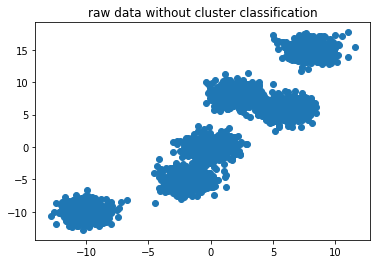

In [59]:
data = Initialization(3000,2)
data.data_visualization()
N = data.N
D = data.D
X = data.X
Y = data.Y

  0%|          | 0/20 [00:00<?, ?it/s]'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/liangchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for

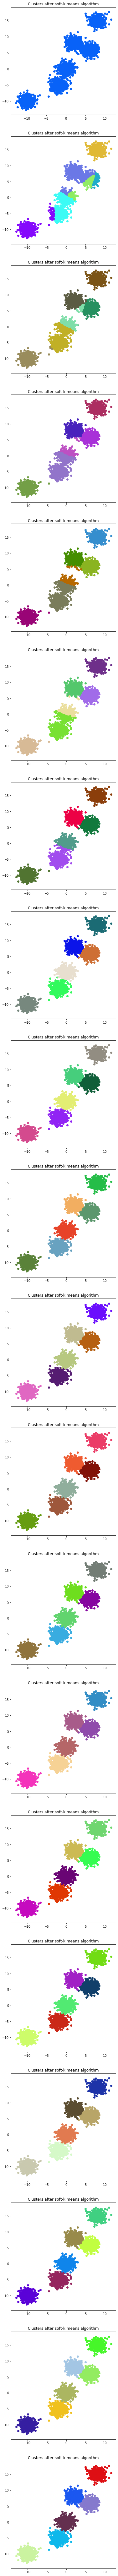

In [61]:
model = soft_k_means(beta=1.0,N=N,epochs=20,num_of_clusters=6,data=X)
model.train(soft=True,plot=True)

### choose K

In [42]:
total_costs= []
dbis = []
purities = []
for k in tqdm(range(10)):
    model = soft_k_means(beta=1.0,N=N,epochs=20,num_of_clusters=k+2,data=X)
    model.train(soft=True,plot=False)
    dbis.append(model.DBI())
    total_costs.append(model.costs[-1])
    purities.append(model.purity(Y))


  0%|          | 0/20 [00:00<?, ?it/s]/Users/liangchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

100%|██████████| 10/10 [01:20<00:00, 10.61s/it]


<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

<Figure size 432x10800 with 0 Axes>

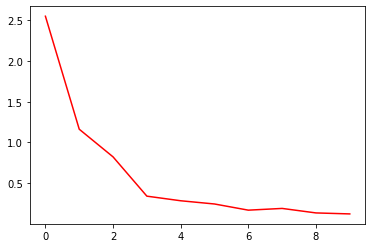

In [44]:
plt.plot(total_costs,'r')

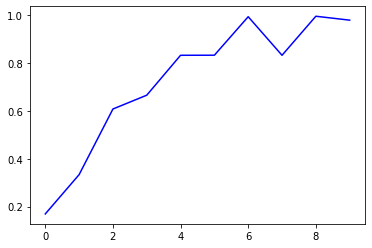

In [45]:
plt.plot(purities,'b')

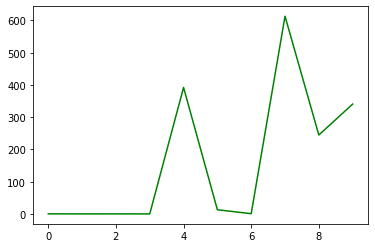

In [46]:
plt.plot(dbis,'g')

In [50]:
model.purity(Y)

0.6666666666666666

### k = 6

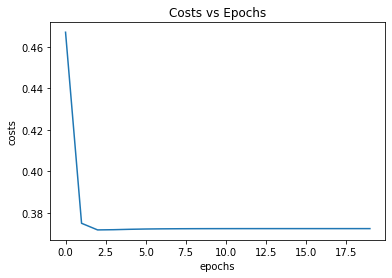

In [51]:
plt.plot(model.costs)
plt.xlabel("epochs")
plt.ylabel("costs")
plt.title("Costs vs Epochs")
plt.show()

In [52]:
model.DBI()

31.85111432730815

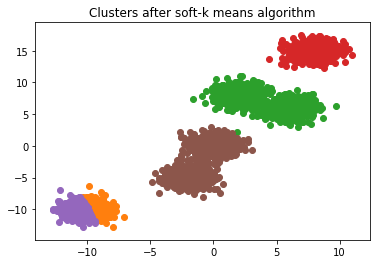

In [53]:
model.plot_clusters(soft=True,uncertainty=False)

### Three kinds of dataset which may fail on the k-means algorithm

1. Concentric circles

2. elongated data (e.g., bivariate normal with one of the directions of covariance being much larger than the other)
   In other words, k-means only tend to solve spherical problems rather than ellipitical problems
3. dataset with largely unbalanced clusters

dataset 1: Concentric circles

In [ ]:
R_inner = np.random.randn(500) + 5
theta = 2*np.pi*np.random.random(500)
X_inner = np.concatenate([[R_inner*np.cos(theta),R_inner*np.sin(theta)]]).T

R_outer = np.random.randn(500) + 10
theta = 2*np.pi*np.random.random(500)
X_outer = np.concatenate([[R_outer*np.cos(theta),R_outer*np.sin(theta)]]).T

X = np.concatenate((X_inner,X_outer))
plt.scatter(X[:,0],X[:,1])

dataset 2: elongated data

In [ ]:
X = np.zeros((1000,2))
X[:500,:] = np.random.multivariate_normal([0,0],[[1,0],[0,20]],500)
X[500:,:] = np.random.multivariate_normal([5,0],[[1,0],[0,20]],500)
plt.scatter(X[:,0],X[:,1])

dataset 3: dataset with largely unbalanced clusters

In [ ]:
X = np.zeros((1000,2))
X[:950,:] = np.random.multivariate_normal([0,0],[[1,0],[0,1]],950)
X[950:,:] = np.random.multivariate_normal([5,0],[[1,0],[0,1]],50)
plt.scatter(X[:,0],X[:,1])

Small tip: np.random.multivariate_normal([0,0],[[1,0],[0,1]],500) is equivalent to np.random.randn(500,2)

In [4]:
data = list(pd.read_csv("https://raw.githubusercontent.com/lazyprogrammer/\
machine_learning_examples/master/nlp_class/all_book_titles.txt",sep='\t',header=None).as_matrix().reshape(-1))


/Users/liangchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [76]:
import os 
path = "/Users/liangchen/Desktop/NLTK/wikipedia"
files = []
for i in os.listdir(path):
    
    files.append(path+"/"+i)


In [77]:
files[0] = "/Users/liangchen/Desktop/NLTK/wikipedia/enwiki-20180620-pages-articles2.xml-p30304p88444-38.txt"

In [79]:
stopwords = list(pd.read_csv("https://raw.githubusercontent.com/lazyprogrammer/\
machine_learning_examples/master/nlp_class/stopwords.txt",header=None).as_matrix().reshape(-1))
stopwords.extend(lst)
stopwords.extend(["this"])

/Users/liangchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [80]:
word_count={}
sentences = []
regex="[-*={|\[]"
address = files[0]
with open(address,'r') as f:
    lines = f.readlines()
for line in lines:
    line = line.strip()
    # some sentences with the beginning of weird symbols in wikipedia data are typically the titles 
    # or some trivial descriptive notes that we are interested in for training purposes
    if len(line)>0 and len(re.findall(regex,line[0]))==0:
        line = line.lower()
        # substitute all non letter characters with whitespace, which only leaves actual words for training
        # Note: <We could also try include the common punctuation marks into training set.>
        line = re.sub('[^a-z0-9\']',' ',line)
        words = line.split()
        tokens=[]
        count_for_stopwords = 0
        # make sure that after dropping the sentence by stopwords, we still have at least 2 words to form a 
        # sentence (with context)
        for w in words:             
            if w in stopwords:
                count_for_stopwords+=1
        if len(words) - count_for_stopwords < 2:
            continue

        for w in words:

            if w in stopwords:
                continue

            tokens.append(w)    
            if w not in word_count:
                word_count[w] = 0
            word_count[w]+=1
        sentences.append(tokens)


        




In [81]:
top2000 = sorted(word_count.items(),key=lambda x: x[1],reverse=True)[:2000]
vocab = [x[0] for x in top2000]
word_index = {v:k for k,v in enumerate(vocab)}
V = len(vocab)
D = len(sentences)
word_doc= np.zeros((V,D))


for word in tqdm(vocab):
    c = 0
    for doc_indx,doc in enumerate(sentences):
        
        if word in doc:
            c+=1
        
        for w in doc:       
            if word == w:
                word_doc[word_index[word],doc_indx]+=1  
    
    word_doc[word_index[word],:]/=c

100%|██████████| 2000/2000 [00:48<00:00, 40.84it/s]


In [11]:
wordnet_lemmatizer = WordNetLemmatizer()
word_index={}
index = 0
regex = '[^a-z0-9\']'
docs = []
for doc in data:
    words = []
    doc = doc.lower()
    doc = re.sub(regex,' ',doc)
    tokens = doc.split()
    for w in tokens:
        
        w = wordnet_lemmatizer.lemmatize(w)
       
        if w in stopwords:
            continue
        
        words.append(w)
        
        if w not in word_index:
            word_index[w] = index        
            index+=1
    docs.append(words)

In [83]:
tsne = TSNE()
Z = tsne.fit_transform(word_doc)

In [106]:
savedir = "/Users/liangchen/Desktop/unsupervised ml"
np.savez('%s/soft_k_means_word_cloud_tsne.npz' % savedir,Z)
    
def load(loaddir):
    
    """Load the trained variables."""
    
    npz = np.load('%s/soft_k_means_word_cloud_tsne.npz' % loaddir)
    
    Z = npz['arr_0']

    return Z


In [13]:
Z = load("/Users/liangchen/Desktop/unsupervised ml")

In [69]:
index_word = {v:k for k,v in word_index.items()}


  0%|          | 0/20 [00:00<?, ?it/s]'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/Users/liangchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value fo

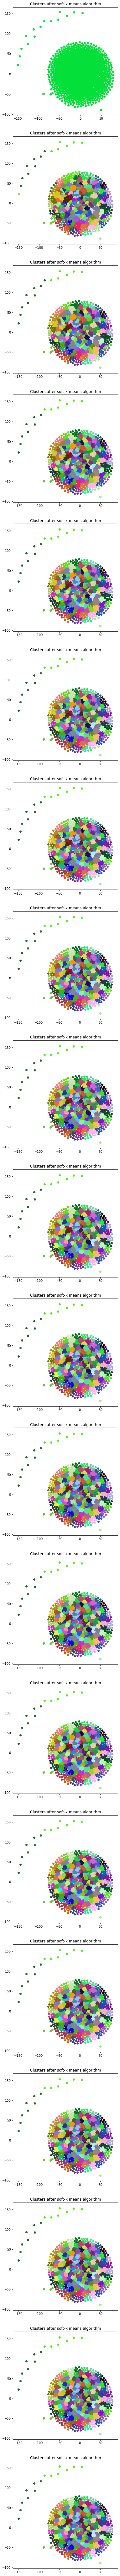

In [87]:
model = soft_k_means(beta=1.0,N=V,epochs=20,num_of_clusters=200,data=Z)
model.train(soft=True,plot=True)

In [88]:
model.costs

[0.02754677146132229,
 0.02350251003797353,
 0.021616988035243288,
 0.02116940265369549,
 0.020909900297006852,
 0.020725655111991786,
 0.020595108662979814,
 0.020492437864592223,
 0.020396296897212975,
 0.020315495759139678,
 0.020263828422681943,
 0.020217204681908036,
 0.02017321077930864,
 0.02012810049878853,
 0.020080614667295493,
 0.020033140264156833,
 0.019995078947129822,
 0.0199634384963757,
 0.019933887576561206,
 0.01990501343028939]

In [101]:
def annotate1(X,labels, index_word_map, eps=0.1):
    N, D = X[labels].shape
    placed = np.empty((N, D))
    for num, i in tqdm(enumerate(labels)):
        x, y = X[i]

        # if x, y is too close to something already plotted, move it
        close = []

        x, y = X[i]
        for retry in range(3):
            for j in range(num):
                diff = np.array([x, y]) - placed[j]

                # if something is close, append it to the close list
                if diff.dot(diff) < eps:
                    close.append(placed[j])

            if close:
            # then the close list is not empty
                x += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
                y += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
                close = [] # so we can start again with an empty list
            else:
            # nothing close, let's break
                break

        placed[num] = (x, y)

        plt.annotate(
          s=index_word_map[i],
          xy=(X[i,0], X[i,1]),
          xytext=(x, y),
          arrowprops={
            'arrowstyle' : '->',
            'color' : 'black',
          }
        )



In [102]:
W = model.W
labels = [[] for _ in range(200)]
for i in range(W.shape[0]):
    indx = W[i,:].argmax()
    labels[indx].append(i)


0it [00:00, ?it/s]'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0it [00:00, ?it/s]

10it [00:00, 2795.46it/s]'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0it [00:00, ?it/s]

12it [00:00, 3052.07it/s]'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


0it [00:00, ?it/s]

11it [00:00, 293

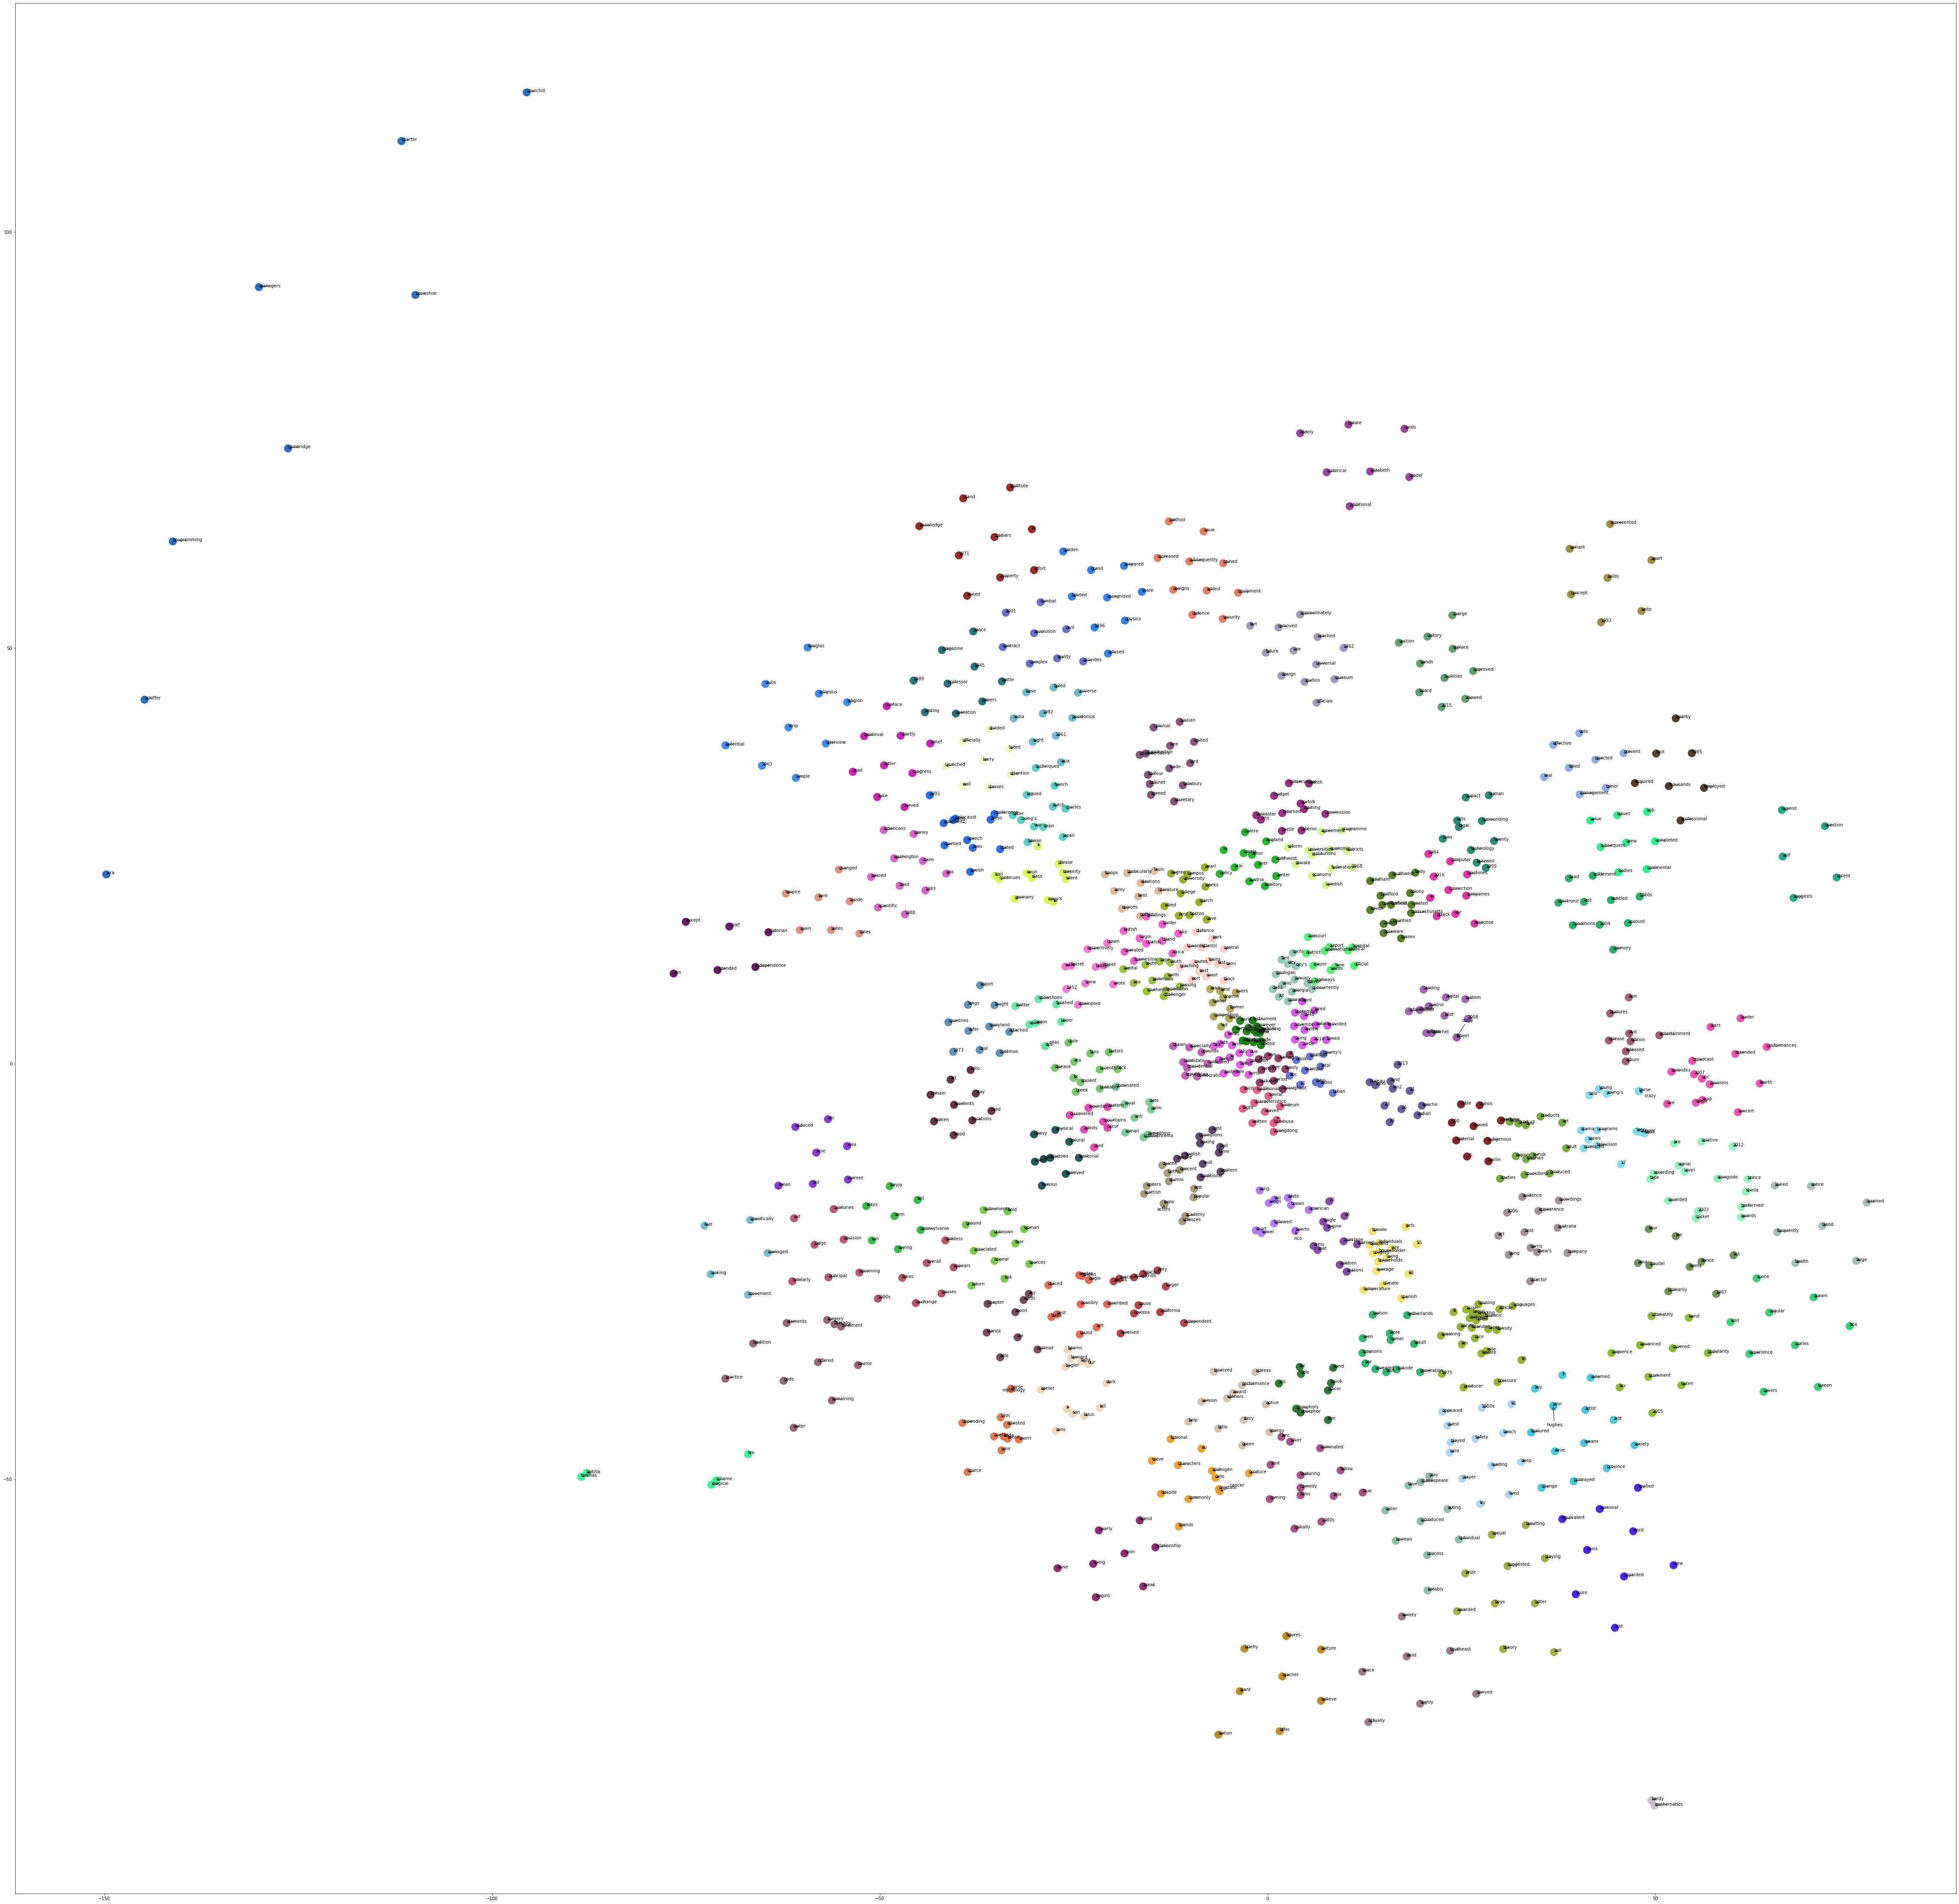

In [103]:
plt.figure(figsize=(80.0, 80.0))
c = 0
for num,i in tqdm(enumerate(labels)):
    if len(i) == 0:
        continue
    color = np.random.random(3)
    plt.scatter(Z[i][:,0],Z[i][:,1],s=300,alpha=0.9,c=color)
    annotate1(Z,labels[num],index_word, eps=0.1)
    c+=1
    if c > 100:
        break
plt.savefig("./test.png")    